# Softmax Regression on MNIST

Implementation of softmax regression (multinomial logistic regression).

## Imports

In [99]:
import time
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

## Settings and Dataset

In [100]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.1
num_epochs = 25
batch_size = 256

# Architecture
num_features = 784
num_classes = 10


##########################
### MNIST DATASET
##########################

train_dataset = datasets.MNIST(root='data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.MNIST(root='data',
                            train=False,
                            transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)


# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape) #NCHW
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [101]:
##########################
### MODEL
##########################

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()

    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)

model.to(device)

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

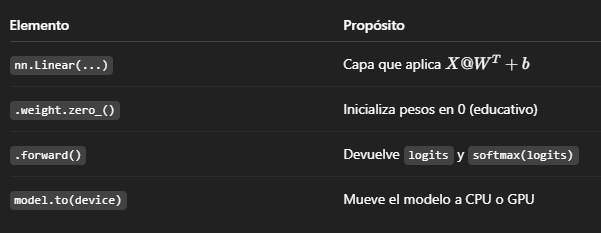

In [102]:
# Manual seed for deterministic data loader
torch.manual_seed(random_seed)


def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0

    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float() / num_examples * 100


start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)

        # note that the PyTorch implementation of
        # CrossEntropyLoss works with logits, not
        # probabilities
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                %(epoch+1, num_epochs, batch_idx,
                len(train_dataset)//batch_size, cost))

    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
            epoch+1, num_epochs,
            compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Batch 000/234 | Cost: 2.3026
Epoch: 001/025 | Batch 050/234 | Cost: 0.7693
Epoch: 001/025 | Batch 100/234 | Cost: 0.5321
Epoch: 001/025 | Batch 150/234 | Cost: 0.5617
Epoch: 001/025 | Batch 200/234 | Cost: 0.5501
Epoch: 001/025 training accuracy: 88.05%
Time elapsed: 0.09 min
Epoch: 002/025 | Batch 000/234 | Cost: 0.4793
Epoch: 002/025 | Batch 050/234 | Cost: 0.3686
Epoch: 002/025 | Batch 100/234 | Cost: 0.4535
Epoch: 002/025 | Batch 150/234 | Cost: 0.3731
Epoch: 002/025 | Batch 200/234 | Cost: 0.4791
Epoch: 002/025 training accuracy: 89.26%
Time elapsed: 0.17 min
Epoch: 003/025 | Batch 000/234 | Cost: 0.4057
Epoch: 003/025 | Batch 050/234 | Cost: 0.4456
Epoch: 003/025 | Batch 100/234 | Cost: 0.3770
Epoch: 003/025 | Batch 150/234 | Cost: 0.3893
Epoch: 003/025 | Batch 200/234 | Cost: 0.2996
Epoch: 003/025 training accuracy: 89.94%
Time elapsed: 0.26 min
Epoch: 004/025 | Batch 000/234 | Cost: 0.4298
Epoch: 004/025 | Batch 050/234 | Cost: 0.3918
Epoch: 004/025 | Batch 100

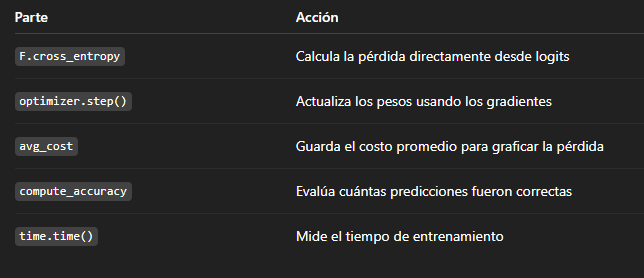

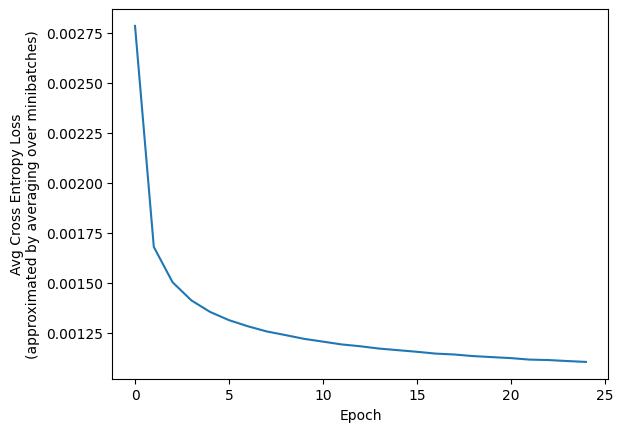

In [103]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


plt.plot(epoch_costs)
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()

In [104]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 92.24%


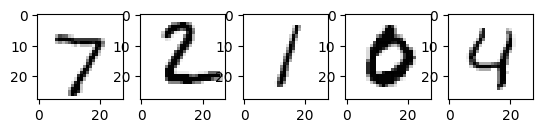

In [105]:
for features, targets in test_loader:
    break

fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [106]:
_, predictions = model.forward(features[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([7, 2, 1, 0, 4])


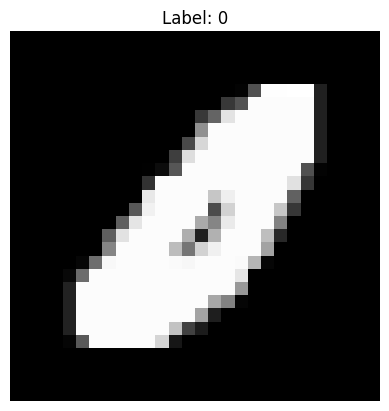

In [107]:
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[idx]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()


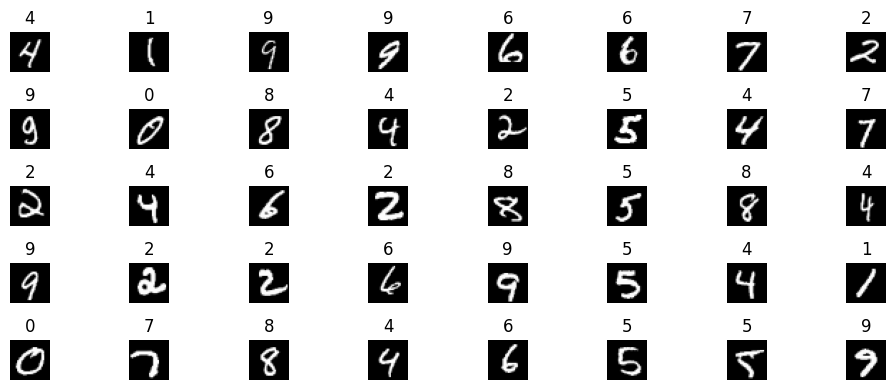

In [108]:
fig, axes = plt.subplots(5, 8, figsize=(10, 4))
for ax in axes.flat:
    idx = random.randint(0, len(train_dataset) - 1)
    image, label = train_dataset[idx]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'{label}')
    ax.axis('off')
plt.tight_layout()
plt.show()


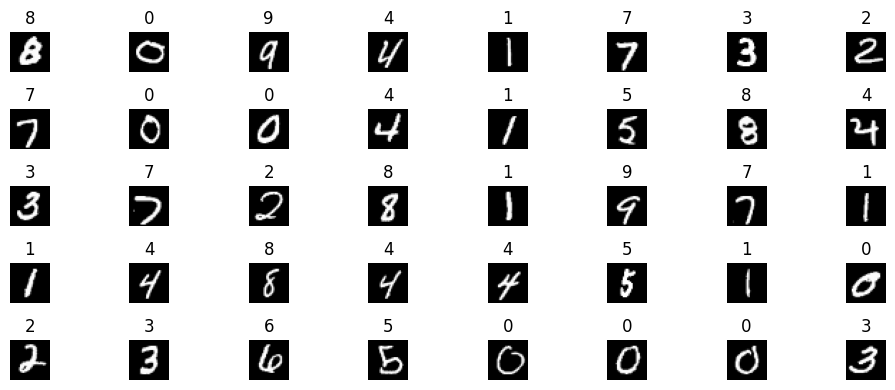

In [109]:
fig, axes = plt.subplots(5, 8, figsize=(10, 4))
for ax in axes.flat:
    idx = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[idx]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'{label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

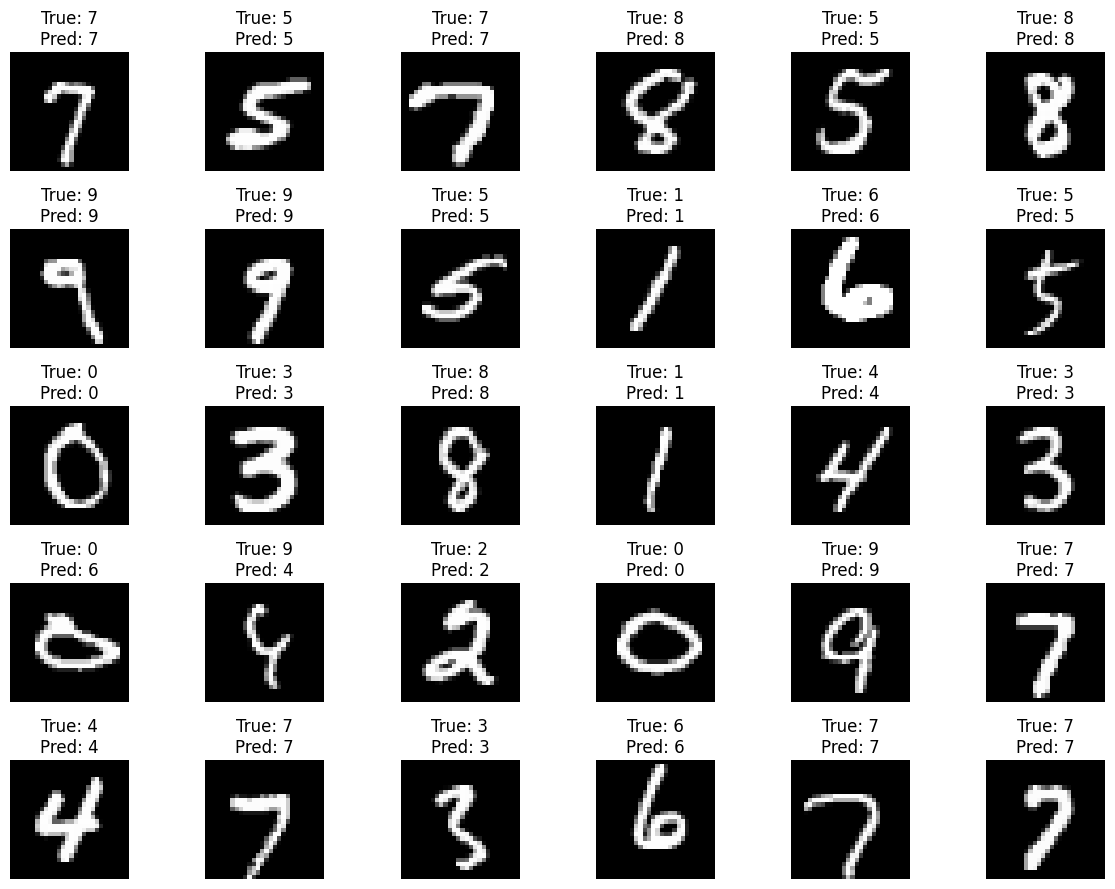

In [110]:
import random

model.eval()
with torch.no_grad():
    fig, axes = plt.subplots(5, 6, figsize=(12, 9))

    for ax in axes.flat:
        # Escoger un índice aleatorio del dataset de prueba
        idx = random.randint(0, len(test_dataset) - 1)

        # Obtener imagen y etiqueta
        image, label = test_dataset[idx]

        # Preparar la imagen para el modelo (shape [1, 784])
        image_tensor = image.view(1, -1).to(device)
        logits, probas = model(image_tensor)
        pred = torch.argmax(probas, dim=1)

        # Visualizar
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f'True: {label}\nPred: {pred.item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


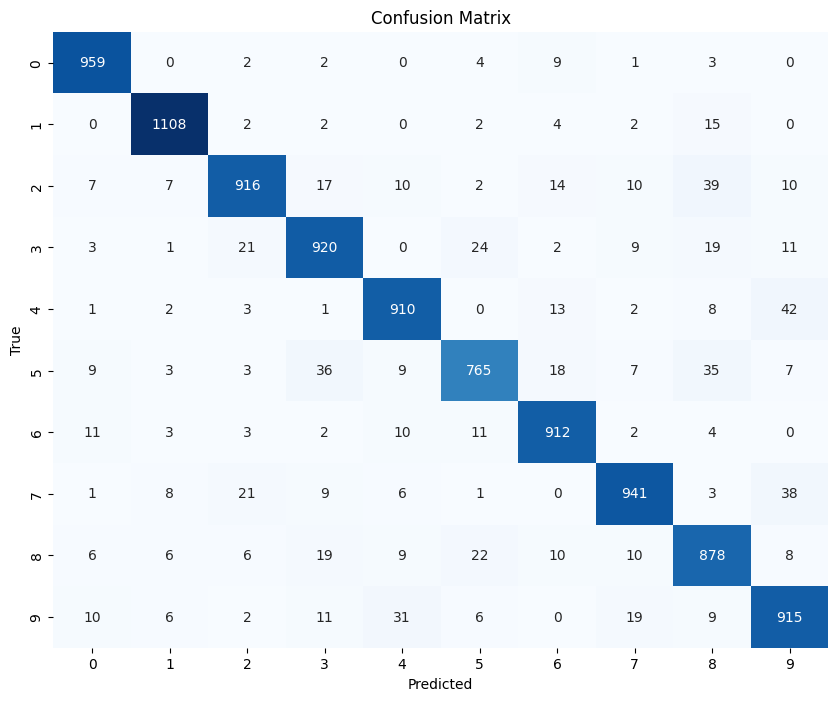

In [111]:
# generar matriz de confusión 
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import seaborn as sns

# Función para calcular la matriz de confusión
def plot_confusion_matrix(model, data_loader, num_classes):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for features, labels in data_loader:
            features = features.view(-1, 28*28).to(device)
            logits, probas = model(features)
            _, preds = torch.max(probas, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
plot_confusion_matrix(model, test_loader, num_classes)